# Analysis of K-means Clustering Algorithms in E-commerce Data Segmentation

Dataset Resource: https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python

In [77]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import DBSCAN


In [47]:
# upload the `kaggle.json` file and configure the Kaggle API
from google.colab import files
uploaded = files.upload()



Saving kaggle.json to kaggle.json


In [49]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

User uploaded file "kaggle.json" with length 68 bytes
mv: cannot stat 'kaggle.json': No such file or directory


In [50]:
# Downloading the dataset
!kaggle datasets download -d vjchoudhary7/customer-segmentation-tutorial-in-python

Dataset URL: https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python
License(s): other
customer-segmentation-tutorial-in-python.zip: Skipping, found more recently modified local copy (use --force to force download)


In [51]:
# Read the file
df = pd.read_csv("customer-segmentation-tutorial-in-python.zip")
# Rename some columns and drop the useless ID column
df.rename(columns={"Annual Income (k$)": "Income", "Spending Score (1-100)": "Spending_Score"}, inplace=True)
df = df.drop(["CustomerID"], axis=1)
df

,Gender,Age,Income,Spending_Score
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40
...,...,...,...,...
195,Female,35,120,79
196,Female,45,126,28
197,Male,32,126,74
198,Male,32,137,18


#Data Exploration
Data exploration, also referred to as exploratory data analysis (EDA), constitutes a crucial preliminary phase in data analysis. During this stage, analysts employ a variety of statistical and visualization techniques to gain a comprehensive understanding of the dataset's characteristics and underlying patterns. This process encompasses summarizing key features, detecting anomalies, identifying relationships between variables, and formulating initial hypotheses.

In [52]:
df.describe()


,Age,Income,Spending_Score
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Gender          200 non-null    object
 1   Age             200 non-null    int64 
 2   Income          200 non-null    int64 
 3   Spending_Score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


In [54]:
df["Gender"].value_counts()


Gender
Female    112
Male       88
Name: count, dtype: int64

# Kernel Density Estimate (KDE)
A histogram is a foundational tool in descriptive statistics that graphically represents the distribution of a dataset. It does so by segmenting the data into discrete intervals known as bins, and displaying the frequency (or count) of data points within each bin. The height of each bar in a histogram reflects the number of observations falling within the corresponding interval. Histograms are invaluable for providing a visual summary of the data, highlighting its central tendency, dispersion, and the presence of any skewness or outliers
* The ages in the dataset range from around 20 to 70 years. The distribution shows a moderate concentration around the ages of 30 to 40, indicating that this age group is the most prevalent within the dataset. The age distribution appears to be somewhat left-skewed, as evidenced by the tail extending towards the older ages. This suggests that there are fewer older individuals compared to younger and middle-aged ones.
* Incomes range from around 20 to 130 units of currency. The central tendency is around 70-75 units, suggesting that this income range is the most common in the dataset.
* Spending scores range from 0 to 100. The central tendency is around 40-60, indicating that the majority of individuals have moderate spending scores. The distribution of spending scores appears to be more evenly distributed with a slight bimodal pattern. This is visible from the two peaks around 40-50 and 70-80, suggesting two different groups of spending behaviors. There are distinct peaks at the spending scores of around 45 and 60. The KDE curve smooths these peaks but still shows two modes, indicating potential segmentation within the spending behavior of the individuals.

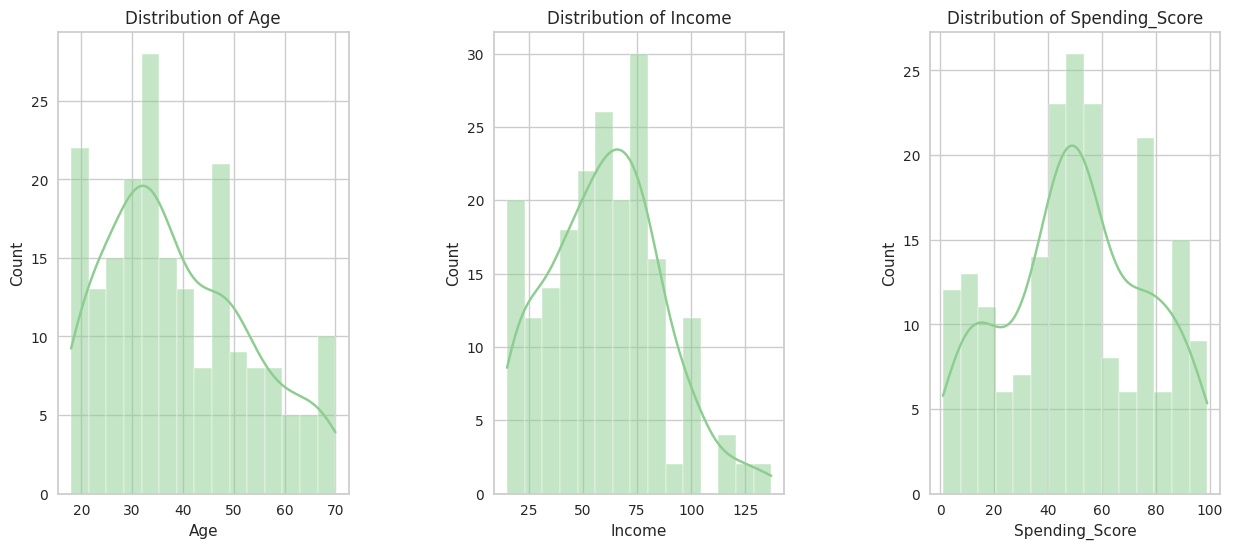

In [55]:
# Plot histograms with kernel density estimates (KDE)
plt.figure(figsize=(15, 6))
sns.set_palette(palette="Greens_d")
sns.set_style("whitegrid")
features = ["Age", "Income", "Spending_Score"]

for i, feature in enumerate(features):
    plt.subplot(1, 3, i+1)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    sns.histplot(df[feature], bins=15, kde=True)
    plt.title(f"Distribution of {feature}")
plt.show()


<Figure size 1000x600 with 0 Axes>

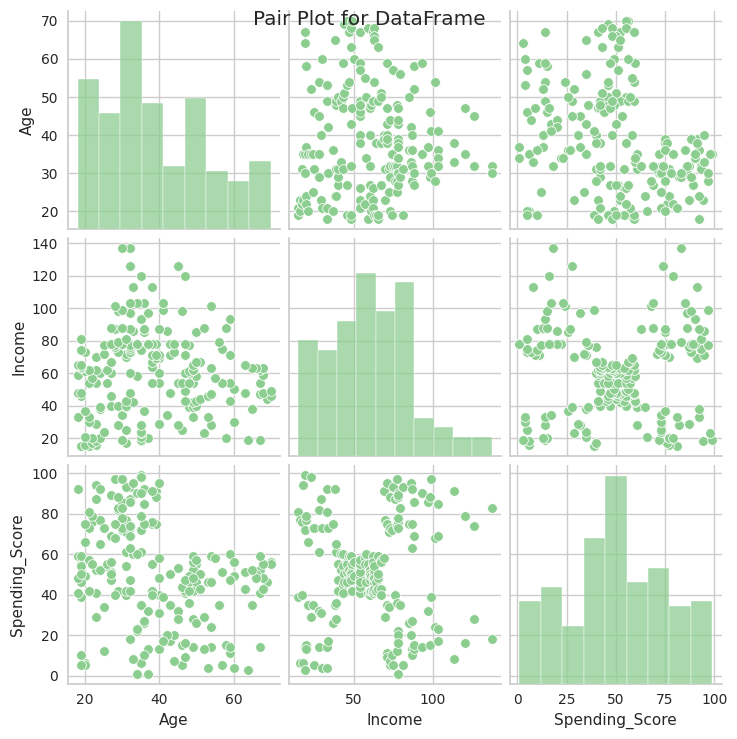

In [56]:
# Create a pair plot
plt.figure(figsize=(10, 6))
sns.pairplot(df)

plt.suptitle("Pair Plot for DataFrame")
plt.show()

* As observed in the plot above, there is no linear correlation between "Age" and "Annual Income".
* From the plot above, we can already observe some clusters. Therefore, it is evident that the features "Spending Score" and "Annual Income" will significantly influence cluster segmentation, as we will demonstrate later in the notebook.
* There is a somewhat negative relationship between "Age" and "Spending Score". Customers aged 40 and above generally have a spending score below 60, whereas younger customers (under 40) tend to have higher spending scores, with many falling in the 70-100 range.

# Data Wrangling
Data preprocessing is the process of transforming raw data into a clean and usable format before analysis. This involves several steps including data cleaning (removing noise and inconsistencies), data transformation (normalizing or scaling data), data integration (combining data from different sources), and data reduction (simplifying data without losing its essence). Effective data preprocessing enhances the quality and reliability of the data, enabling more accurate and efficient analysis.

In [57]:
# Check for any missing value
df.isnull().sum()
# or df.duplicated().sum()
# There is no missing value in the dataset

Gender            0
Age               0
Income            0
Spending_Score    0
dtype: int64

In [58]:
# Detect any duplicated value
df.duplicated().any()
# There is no duplicated value in the datasets

False

In [59]:
# One-hot encoding
df["Gender"] = df["Gender"].astype("category")
df["Gender"] = df["Gender"].cat.codes
df

,Gender,Age,Income,Spending_Score
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40
...,...,...,...,...
195,0,35,120,79
196,0,45,126,28
197,1,32,126,74
198,1,32,137,18


In [76]:
# Since the clusturing methods use distance as a metric to create categories, we need to scale the data.
# useful resource: https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02
scaler = StandardScaler()
scaled_df = scaler.fit(df)
scaled_df = scaler.transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=df.columns)
scaled_df


,Gender,Age,Income,Spending_Score
0,1.128152,-1.424569,-1.738999,-0.434801
1,1.128152,-1.281035,-1.738999,1.195704
2,-0.886405,-1.352802,-1.700830,-1.715913
3,-0.886405,-1.137502,-1.700830,1.040418
4,-0.886405,-0.563369,-1.662660,-0.395980
...,...,...,...,...
195,-0.886405,-0.276302,2.268791,1.118061
196,-0.886405,0.441365,2.497807,-0.861839
197,1.128152,-0.491602,2.497807,0.923953
198,1.128152,-0.491602,2.917671,-1.250054


# K-means Model

# Elbow Method
The elbow method is a graphical method for finding the optimal K value in a k-means clustering algorithm. The elbow graph shows the within-cluster-sum-of-square (WCSS) values on the y-axis corresponding to the different values of K (on the x-axis). In the Elbow method, we vary the number of clusters (K) from 1 to 10 and calculate the WCSS (Within-Cluster Sum of Squares) for each K. WCSS represents the sum of squared distances between each data point and the centroid within a cluster. By plotting WCSS against K, we typically observe a plot resembling an elbow shape. As the number of clusters increases, the WCSS decreases, with the WCSS being largest when K equals 1. The graph shows a rapid decline at a certain point, forming an elbow, after which it flattens and runs almost parallel to the X-axis. The K value at this elbow point is considered the optimal number of clusters.

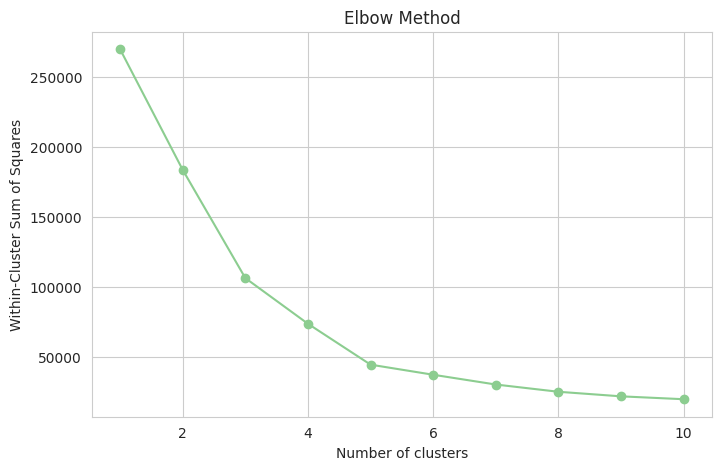

In [ ]:
X = df[["Spending_Score", "Income"]].values

ssd = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(X)
    ssd.append(kmeans.inertia_)

# Plot the elbow method graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), ssd, marker="o")
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("Within-Cluster Sum of Squares")
plt.show()
# plot shows a reduction of a distortion score, so we select k = 5

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


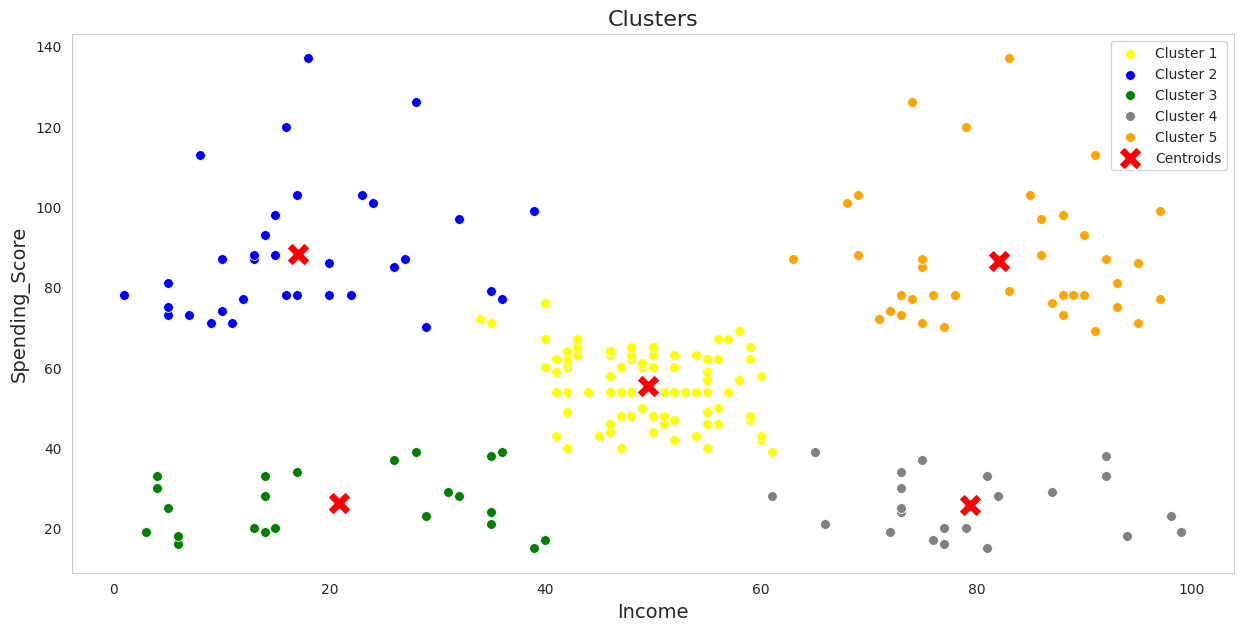

In [ ]:
# Fit K-Means to the dataset
kmeans = KMeans(n_clusters = 5, init = "k-means++", random_state = 42)
y_kmeans = kmeans.fit_predict(X)

# Visualization
plt.figure(figsize=(15, 7))
colors = ["yellow", "blue", "green", "grey", "orange"]
labels = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5"]

# Plot each cluster
for i in range(5):
    sns.scatterplot(x=X[y_kmeans == i, 0], y=X[y_kmeans == i, 1],
                    color=colors[i], label=labels[i], s=50)
# Plot centroids
sns.scatterplot(x=kmeans.cluster_centers_[:, 0], y=kmeans.cluster_centers_[:, 1],
                color="red", label="Centroids", s=300, marker="X")

# Customize the plot
plt.title("Clusters", fontsize=16)
plt.xlabel("Income", fontsize=14)
plt.ylabel("Spending_Score", fontsize=14)
plt.legend()
plt.grid(False)
plt.show()

# K-Means Outcome
Cluster 1 (Yellow): This cluster represents customers with moderate income levels (ranging roughly from 40 to 60) and medium spending scores (centered around 50). These customers might be average spenders with average income.

Cluster 2 (Blue): Comprising customers with lower incomes (below 40) but high spending scores (above 60). This could indicate a segment of customers who spend a significant portion of their income despite earning less.

Cluster 3 (Green): These customers have low incomes (below 40) and low spending scores (below 40). They might represent a more frugal or budget-conscious segment, spending less likely due to lower income.

Cluster 4 (Grey): This group has a wide range of income levels (40 to 100) but consistently low spending scores (below 40). It might represent high earners who are conservative with their spending, possibly savers or investors.

Cluster 5 (Orange): Customers in this cluster have high incomes (above 60) and high spending scores (above 60). These are likely affluent customers who spend more, indicating a luxury or high-value customer segment.

# Silhouette Score
Silhouette Score is a tool for assessing the appropriateness of clustering results by providing a quantitative measure of how well-defined and distinct the clusters are. The Silhouette Score quantifies how well a data point fits into its assigned cluster and how distinct it is from other clusters. It measures the cohesion and separation of data points within clusters and helps determine whether the clusters are well-separated and internally homogeneous.
* The silhouette coefficient values range from -1 to +1.
* Values close to +1 indicate that the samples are well-clustered, meaning they are closer to their own cluster centroid than to other clusters.
* Values around 0 indicate that the samples are on or very close to the decision boundary between two neighboring clusters.
* Negative values indicate that the samples might have been assigned to the wrong cluster.

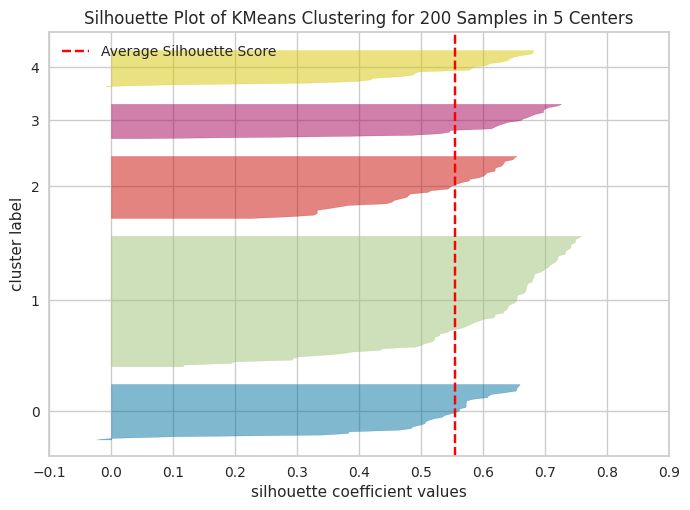

In [78]:
# Check the quality of each cluster
model = KMeans(n_clusters=5, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X)
visualizer.show()
plt.show()

# Silhouette Outcom
* The average silhouette score, represented by the red dashed line, measures how similar a point is to its own cluster compared to other clusters. Ideally, this score should be close to +1, indicating well-defined clusters. In our analysis, the average silhouette score is around 0.5 to 0.6, suggesting moderately good clustering. This indicates that, overall, the clusters are reasonably well-defined and the majority of data points are appropriately assigned to their respective clusters.
* The width of each cluster in the silhouette plot corresponds to the number of samples in that cluster. Wider bars indicate clusters with more samples, while narrower bars indicate clusters with fewer samples. In our plot, all clusters appear to have a reasonable number of samples without significant imbalance. This balance is crucial for ensuring that no single cluster dominates the dataset, allowing for a more meaningful analysis of each cluster.
* Cluster separation is another critical aspect highlighted by the silhouette plot. Well-separated clusters have wider silhouette bars that do not overlap with others. If clusters have thin bars or overlap significantly, it suggests that the samples might not be well separated. In our plot, the clusters are well-separated, as there is a clear distinction between the silhouette bars for each cluster. This separation indicates that the clustering algorithm successfully differentiated between distinct groups in the data.
* In conclusion, the well-separated clusters collectively suggest that the K-Means algorithm with 5 clusters has effectively partitioned the dataset into meaningful groups. This analysis confirms that the clustering model is performing well, with only a few points potentially requiring further investigation for optimal cluster assignment.